In [16]:
import os, sys, glob
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np, matplotlib, scipy, healpy as hp, time

%matplotlib inline
from matplotlib import pyplot as plt, colors
from scipy import stats, interpolate, optimize
import numpy.lib.recfunctions as rf

In [17]:
# Load in both the simulation and the data
sim = np.load("../counting_analysis/data/IC86_2012_MC.npy")
data = np.load("../counting_analysis/data/IC86_2012_exp.npy")

# Reduce the number of events in the simulation
# to a manageable level.
N = len(sim)
n_keep = len(sim)//10
sim = np.random.choice(sim, 
           np.min([n_keep, len(sim)]), replace=False)    # cut down to n_keep events
sim['ow'] /= float(n_keep)/float(N)    # correct the weights
print("Reduced the number of simulation events from ",
     "{} to {}".format(N, len(sim)))
print()

# Show the possible keys available here:
print("Keys available in simulation:")
print(sorted(sim.dtype.names))
print()

print("Keys available in data:")
print(sorted(data.dtype.names))

Reduced the number of simulation events from  11595414 to 1159541

Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']

Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']


In [18]:
# Also load in the "GoodRunList" (GRL), a file that tells
# us when the detector was taking good data. 
grl = np.load("../counting_analysis/data/GRL/IC86_2012_exp.npy")

# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [19]:
# We will need the average rate for our analysis.
# We can get this by either counting the number of
# events in data or the number of events recorded
# in the GRL and dividing by the total good livetime.
total_events = len(data)
total_livetime = np.sum(grl['livetime'])

average_rate = total_events / total_livetime
print("Data has an average rate of {:4.2f} events/day".format(average_rate))

Data has an average rate of 339.96 events/day


In [20]:
# Define the parameters of our analysis.
# We're going to simplify things a little bit to start
# and ignore the impact of detector downtime, which
# would need to be included in an actual analysis.
# 
# Our first test analysis will look for an excess of 
# neutrino events in 1000 seconds across the entire sky.
time_window = 1000 # seconds
time_window /= (24*3600.) # converted to days, since our rate is in days.

# We will be using the data to model the background in
# our test analysis. How many background events should
# we expect in our analysis?
n_expected = average_rate * time_window
print("We expect an average of {:4.3f} background events in our "\
      "{:4.3f} day time window.".format(n_expected, time_window))

We expect an average of 3.935 background events in our 0.012 day time window.


In [21]:
# Write some helper functions that we can use 
# later. Specifically, we want to be able to 
# calculate the angular distance between two
# directions and to produce a trial including
# signal and background.
def to_unit_vector(ra, dec):
    return np.array([np.cos(ra)*np.cos(dec),
                     np.sin(ra)*np.cos(dec),
                     np.sin(dec)])

def angular_distance(ra_A, dec_A, ra_B, dec_B): 
    unit_A = to_unit_vector(ra_A, dec_A)
    unit_B = to_unit_vector(ra_B, dec_B)
    
    if len(unit_A.shape) != 1:
        return np.arccos(np.dot(unit_A.T, unit_B))
    else:
        return np.arccos(np.dot(unit_A, unit_B))


In [22]:
# We're going to use a "true" pdf for the signal: 
# We're just going to pick out events that have a
# true direction near to the source. This'll be used
# for when we want to add some signal to our trials
def true_signal_pdf(event,
                    source_ra, 
                    source_dec):
    distance = angular_distance(event['trueRa'], 
                                event['trueDec'], 
                                source_ra, 
                                source_dec)
    sigma = event['angErr']
    return (1.0)/(2*np.pi*sigma**2) * np.exp(-(distance)**2/(2*sigma**2))

# A trial is one simulated observation. In our case,
# our analysis is looking at 1000 second time windows
# which may have signal and background events. Define
# a function which can produce a trial for us.
# This time, we want to return the directional info
# for the selected events. To do this, we need to do
# some magic near the end of the function.
def produce_trial(n_background = n_expected,
                  N=0,
                  gamma=-2,
                  source_ra = np.pi/2,
                  source_dec = np.pi/6,
                  window = time_window,
                  data=data,
                  sim=sim,
                  random_seed = None):
    
    if random_seed != None:
        np.random.seed(random_seed)
        
    # We're here going to sample background events from
    # our data. This is a trick we use, since almost all
    # events from our data will be background. This saves
    # us from having to pick a background spectrum.
    n_background_observed = scipy.stats.poisson.rvs(n_background)
    background = np.random.choice(data, n_background_observed)
        
    # Do we want signal events?
    if N > 0:
        # Use what we know about weighting to pick events
        # from a power law. Here, I'm going to use a power
        # law with an index of -2 and E0 of 100 TeV
        weights = sim['ow'] *\
                  (N * (sim['trueE']/100.e3)**gamma) *\
                   window * 24*3600

        signal_p = true_signal_pdf(sim, source_ra, source_dec)
        signal_p /= np.sum(signal_p)

        n_signal_observed = scipy.stats.poisson.rvs(np.sum(weights))
        signal = np.random.choice(sim, n_signal_observed,
                                  p = signal_p)

        #print("added {} signal events".format(signal.shape[0]))

        # Because we want to return the entire event and not just the
        # number of events, we need to do some numpy magic. Specifically,
        # we need to remove the fields in the simulated events that are
        # not present in the data events. These include the true direction,
        # energy, and 'oneweight'.
        signal = rf.drop_fields(signal, [n for n in signal.dtype.names \
                                         if not n in background.dtype.names])
    else:
        signal = np.empty(0, dtype=background.dtype)
    return np.concatenate([background, signal])

In [23]:
# Produce a single trial. Here, we pass a "seed"
# value to the function so that we can reproduce
# the trial later if we want to. If you want it to
# be random, set seed=None.
seed = 0
trial = produce_trial(N=2e-15, random_seed=seed)
print("Got {} events for this trial".format(len(trial)))
print(trial)
print(trial.dtype.names)

Got 12 events for this trial
[(    121751, 17568598, 0, 2.30680808, -0.61891759, 3.23841328, 0.95089633, 56315.29186733, 5.22005328, 0.00671682)
 (    120796, 47200058, 0, 4.92617801, -0.24786577, 4.59252033, 1.32327035, 56211.20936199, 3.59446253, 0.00153484)
 (    120667, 34861498, 0, 3.99078764,  0.19244637, 2.00954121, 1.76239926, 56183.72456093, 3.04826327, 0.01302006)
 (    120849, 40407048, 0, 2.52312287,  0.32456057, 0.55874837, 1.8943615 , 56223.15219616, 2.80203533, 0.00919334)
 (    121715, 65504829, 0, 5.53648497, -0.18466367, 1.1664483 , 1.38707229, 56312.48391779, 4.55083719, 0.01699111)
 (    120420, 61021683, 0, 0.74340587, -0.30195675, 2.46160594, 1.26968149, 56115.46654026, 4.55688186, 0.00652001)
 (1102901423,    62269, 0, 1.56963008,  0.52713858, 1.86805673, 2.09785276, 55927.01967593, 3.23492078, 0.0171873 )
 (1102904186,   135348, 0, 1.50309375,  0.53138791, 1.93458594, 2.10218073, 55927.01967593, 2.87082372, 0.03502499)
 (1102903372,    63417, 0, 1.57676558,  0.5

In [24]:
# We now want to write some code to add an "energy weight"
# to the TS calculation. This weight will be defined to be
# the fraction of the signal (w_s) or background (w_b) above
# this event's energy.
# We'll start with background. We need to be able find out
# what fraction of the background events (ie, our data) are
# above an event's energy. In order to make this simpler and
# computational feasible, we'll want to start by sorting the
# background event energies.
sorted_bg_loge = np.sort(data['logE'])
def background_energy_weight(events,
                             sorted_bg_loge = sorted_bg_loge,
                             minimum = 1.0/len(data)):
    # Take the events we have and find where they fall in the
    # background energy distribution. We'll use a binary search
    # from numpy in order to make this work.
    event_indicies = np.searchsorted(sorted_bg_loge,
                                     events['logE']).astype(float)
    
    # The fraction below is the index / the number of data events
    fraction_below = event_indicies / len(sorted_bg_loge)
    
    # and the fraction above is 1.0 - fraction_below
    # Return either that value or the minimum, whichever
    # is larger.
    return np.maximum(1.0 - fraction_below, minimum)


# Now we need to set up the signal energy weights. This is
# a bit more complicated, since we want to have it work for
# any given spectral index. 
# Let's start by writing a function to do this for a single
# spectral index. We only care about the shape here, so the
# flux normalization and time window length aren't important.
def signal_energy_weight(events,
                         gamma = -2,
                         sim = sim):
    # Calculate the event weights using this gamma
    weights = sim['ow'] * (sim['trueE']/100e3)**gamma
    
    # What fraction of the signal is above each energy?
    is_above = (np.atleast_2d(sim['logE']).T > np.atleast_2d(events['logE']))
    return np.sum(weights*is_above.T, axis=1)/np.sum(weights)

# This function will be pretty slow: it needs to compare
# to the full simulation for each event and does the summations
# Try calculating the signal and background weights for 5 events
print(background_energy_weight(sim[:5]))
print(signal_energy_weight(sim[:5]))

# And the ratio
print(signal_energy_weight(sim[:5])/background_energy_weight(sim[:5]))

[0.39194386 0.7524677  0.63190026 0.90893867 0.68502011]
[0.64282558 0.88100556 0.81845644 0.95760548 0.84604586]
[1.64009606 1.17082176 1.29523041 1.05354246 1.23506718]


In [25]:
# Our signal PDF at this stage consists of just
# a spatial part. In the case of the current dataset,
# a Gaussian spatial PDF will work. In the case where
# your angular unceratinties ("angErr") get larger
# than a couple of degrees, you should probably use
# a von-Mises distribution instead.
def signal_pdf(event,
               test_ra, 
               test_dec):    
    sigma = event['angErr']
    x = angular_distance(event['ra'], event['dec'], 
                         test_ra, test_dec)
    
    return (1.0/(2*np.pi*sigma**2))*np.exp(-x**2/(2*sigma**2))

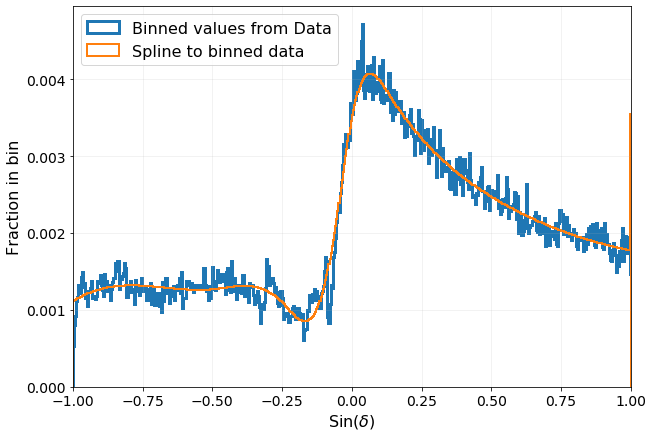

In [26]:
# Our background PDF only depends on declination.
# In order for us to capture the dec-dependent
# behavior, we first take a look at the dec values
# in the data. We can do this by histogramming them.
fig, ax = plt.subplots(figsize=(10, 7))

sin_dec = np.sin(data['dec'])
bins = np.linspace(-1.0, 1.0, 501)

# Make the background histogram. Note that we do NOT
# want to use density=True here, since that would mean
# that our spline depends on the original bin widths!
hist, bins, _ = ax.hist(sin_dec, 
                        bins=bins, 
                        histtype='step', 
                        linewidth=3,
                        weights=np.ones_like(data['dec'])/len(data['dec']),
                        label='Binned values from Data')

# These values have a lot of "noise": they jump
# up and down quite a lot. We could use fewer
# bins, but that may hide some features that
# we care about. We want something that captures
# the right behavior, but is smooth and continuous.
# The best way to do that is to use a "spline",
# which will fit a continuous and differentiable
# piecewise polynomial function to our data. 
# We can set a smoothing factor (s) to control
# how smooth our spline is.
bg_p_dec = interpolate.UnivariateSpline(bins[:-1]+np.diff(bins)/2., 
                                        hist,
                                        bbox=[-1.0, 1.0],
                                        s=1.5e-5,
                                        ext=1)

# Plot this too, so we can see how it compares
# to the histogram.
bg_p_dec_hist, bins, _ = ax.hist(bins, 
                                 bins=bins,
                                 weights=bg_p_dec(bins), 
                                 histtype='step',
                                 linewidth=2,
                                 label = 'Spline to binned data')

ax.legend(loc='upper left', fontsize=16)
ax.grid(alpha=0.2)
ax.set_xlim(-1, 1)
ax.set_xlabel(r'Sin($\delta$)', fontsize=16,)
ax.set_ylabel("Fraction in bin", fontsize=16)
ax.tick_params(labelsize=14)

In [27]:
# To get the declination-dependent background PDF,
# we can now just call the background spline. Note
# that we splined in sin(dec), so we need to pass
# that to the spline. 
def background_pdf(event,
                   test_ra, 
                   test_dec):
    background_likelihood = (1/(2*np.pi))*bg_p_dec(np.sin(event['dec']))
    return background_likelihood

In [28]:
# Our events will consist of some unknown combination
# of signal events (described by the PDF "signal_pdf", S)
# and background events (described by "background_pdf", B).
# We'll call the number of signal events ns.
# Then the total likelihood will therefore be 
#
# L_i = (ns/N)*S + (nb/N)*B
#     = (ns/N)*S + ((N-ns)/N)*B
#
# which we will sum over all events i in our trial.
# We'll evaluate these at a "test point" in RA, dec.
def spatial_llh(event,
                test_ra,
                test_dec,
                ns = 0,
                minimize = True):
    N = len(event)
    if N==0: 
        return 0, [-1,]
    
    # Check: ns cannot be larger than N.
    if ns > N: 
        ns = N - 0.0001

    S = signal_pdf(event, test_ra, test_dec)
    B = background_pdf(event, test_ra, test_dec)
    
    def get_ts(ns):
        ts = (ns/N*(S/B-1))+1
        return -2*np.sum(np.log(ts))
    
    if minimize:
        result = scipy.optimize.minimize(get_ts,
                                         x0 = [ns,],
                                         bounds = [[0, N],],
                                         method = 'SLSQP',
                                         tol = 1e-5,)
        return -1*result.fun, result.x
    
    else:
        return -1*get_ts(ns), [ns,]

In [29]:
# Write a function that can produce our
# trials for us. This'll help when we need
# to calculate our sensitivities, since we'll
# need to call this a lot.
def produce_n_trials(ntrials,
                        
                     # Parameters to control the true signal, background
                     n_background = n_expected, 
                     N=0, 
                     gamma=-2, 
                     source_ra = np.pi/2, 
                     source_dec = np.pi/6, 
                     
                     # Parameters to control where/when you look
                     test_ns = 0,
                     test_ra = np.pi/2,
                     test_dec = np.pi/6,
                     window = time_window, 
                     
                     # The data to use
                     data=data, 
                     sim=sim, 
                     
                     minimize = True,
                     random_seed = None,
                     verbose=True):
    
    llhs = []
    fit_info = {'ninj':[], 'ns':[],}
    for i in range(ntrials):
        # Get the events for this trial.
        trial = produce_trial(n_background=n_expected, 
                               N=N, 
                               gamma=gamma, 
                               source_ra=source_ra, 
                               source_dec=source_dec, 
                               window=time_window, 
                               data=data, 
                               sim=sim, 
                               random_seed = random_seed)

        # How many signal events were actually
        # injected?
        ninj = (trial['run']>200000).sum()
        
        # And the likelihood for the trial
        llh, bestfit = spatial_llh(trial, 
                                  test_ra, 
                                  test_dec,
                                  ns = test_ns,
                                  minimize = minimize,
                                  )
        
        fit_info['ninj'].append(ninj)
        fit_info['ns'].append(bestfit[0])
        
        llhs.append(llh)
    return llhs, fit_info
    
# Run trials for a few different values of N.
# Here, I'll assume ns=1 for all cases.
import time
start = time.time()
background_ts, background_info = produce_n_trials(1000, test_ns=0, minimize=True)
a = time.time()
print("Background took {} seconds".format(a-start))
signal_16, signal_16_info = produce_n_trials(500, N=1e-16, test_ns=0, minimize=True)
b = time.time()
print("1e-16 took {} seconds".format(b-a))
signal_15, signal_15_info = produce_n_trials(500, N=1e-15, test_ns=0, minimize=True)
c = time.time()
print("1e-15 took {} seconds".format(c-b))
signal_14, signal_14_info = produce_n_trials(500, N=1e-14, test_ns=0, minimize=True)
d = time.time()
print("1e-14 took {} seconds".format(d-c))

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


Background took 0.6686758995056152 seconds
1e-16 took 141.36783003807068 seconds
1e-15 took 139.11585187911987 seconds
1e-14 took 138.23801922798157 seconds


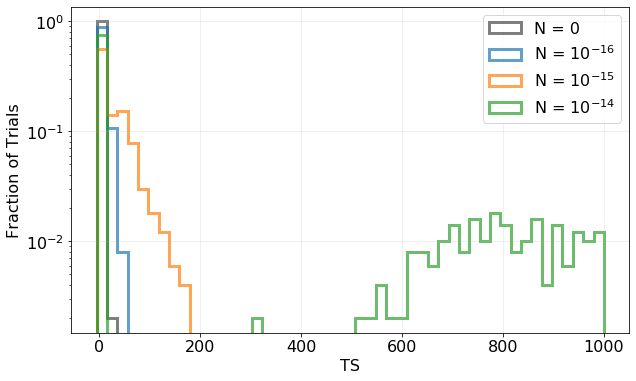

In [15]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-5, 1000, 50)

ax.hist(background_ts,
        bins = bins,
        weights = np.ones_like(background_ts)/len(background_ts),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0')

ax.hist(signal_16,
        bins = bins,
        weights = np.ones_like(signal_16)/len(signal_16),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-16}$')

ax.hist(signal_15,
        bins = bins,
        weights = np.ones_like(signal_15)/len(signal_15),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$')

ax.hist(signal_14,
        bins = bins,
        weights = np.ones_like(signal_14)/len(signal_14),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-14}$')

ax.legend(loc='upper right', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


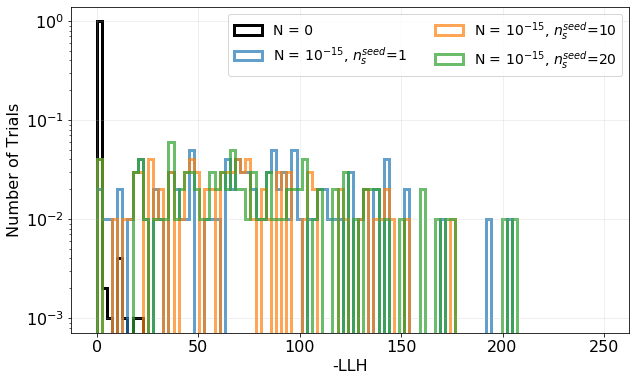

In [16]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 250, 100)

ax.hist(background_ts,
        bins = bins,
        weights = np.ones_like(background_ts)/len(background_ts),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        label = r'N = 0')

for ns in [1, 10, 20]:
    signal_ts, _ = produce_n_trials(100, 
                                 N=1e-15, 
                                 test_ns=ns,
                                minimize=True,)
    ax.hist(signal_ts,
        bins = bins,
        weights = np.ones_like(signal_ts)/len(signal_ts),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$, $n^{seed}_s$' + '={}'.format(ns))

ax.legend(loc='upper right', ncol=2, fontsize=14,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("-LLH", fontsize=16)
ax.set_ylabel("Number of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

4 0


/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


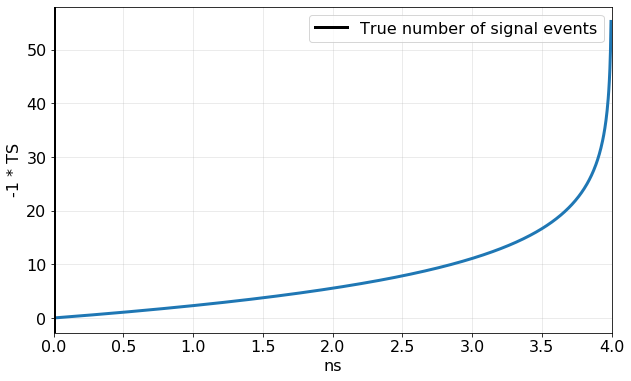

In [17]:
# Produce a single trial that we can use to answer the
# question "What does the TS look like as a function of ns?"
trial = produce_trial(N=0)

# How many signal events are there really in this trial?
# Use a trick of this dataset to ID signal events.
# This works since the simulated events have the
# runs set to very large numbers while the data
# (our background events) have values below 200,000.
ns_true = (trial['run']>200000).sum()
print(len(trial['run']), ns_true)

ns_values = np.linspace(0, len(trial), 1000)
ts_values = []
for ns in ns_values:
    # Calculate the spatial LLH for this ns and trial
    # How do we call the spatial likelihood for this
    # trial and ns with a source at RA=pi/2, dec=pi/6?
    llh, _ = spatial_llh(trial,
                      np.pi/2,
                      np.pi/6,
                      ns = ns,
                      minimize = False,)
    ts_values.append(llh)

# numpy arrays are easier to do calculations with than lists
ts_values = np.array(ts_values)
    
# Plot -1*LLH vs ns for this trial
# Note that we're going to plot -1*LLH here.
fig, ax = plt.subplots(figsize=(10,6))

# Add your plotting line here
ax.plot(ns_values, 
        -1*ts_values,
        linewidth=3,)

ax.axvline(ns_true,
            color='k',
           linewidth=3,
            label = 'True number of signal events')

ax.grid(alpha=0.3)
ax.set_xlim(ns_values.min(), ns_values.max())
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("-1 * TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)

No handles with labels found to put in legend.


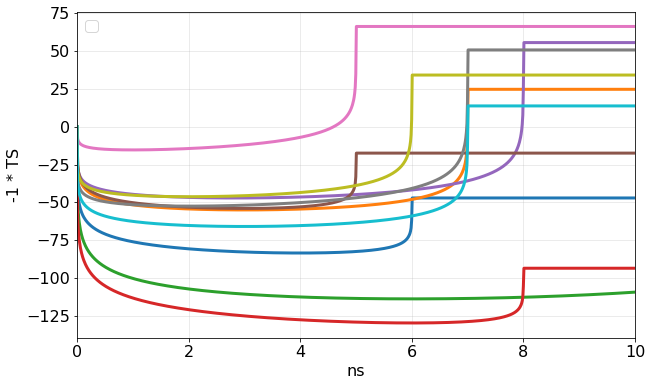

In [18]:
# Plot -1*LLH vs ns for this trial
# Note that we're going to plot -1*LLH here.
fig, ax = plt.subplots(figsize=(10,6))

for i in range(10):
    # Produce a single trial that we can use to answer the
    # question "What does the TS look like as a function of ns?"
    trial = produce_trial(N=1e-15)

    ns_values = np.linspace(0, 10, 1000)
    ts_values = []
    for ns in ns_values:
        # Calculate the spatial LLH for this ns and trial
        # How do we call the spatial likelihood for this
        # trial and ns with a source at RA=pi/2, dec=pi/6?
        llh, _ = spatial_llh(trial,
                              np.pi/2,
                              np.pi/6,
                              ns = ns,
                            minimize = False,)
        ts_values.append(llh)

    # numpy arrays are easier to do calculations with than lists
    ts_values = np.array(ts_values)

    # Add your plotting line here
    ax.plot(ns_values, 
            -1*ts_values,
            linewidth=3,)

ax.grid(alpha=0.3)
ax.set_xlim(ns_values.min(), ns_values.max())
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("-1 * TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)

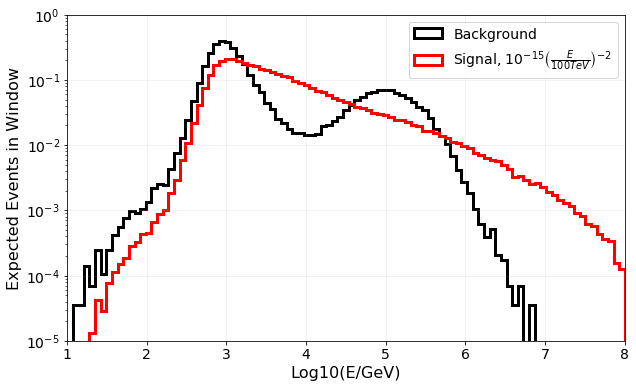

In [19]:
# Plot our signal and background energy distributions
fig, ax = plt.subplots(figsize=(10,6))

bins = np.linspace(1, 8, 100)

# background
bg_w = np.ones(len(data), dtype=float) * time_window / grl['livetime'].sum()
ax.hist(data['logE'],
        bins = bins,
        weights = bg_w,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        label = 'Background')

# signal
sig_w = sim['ow'] * 1e-15 * (sim['trueE']/100e3)**-2 * time_window * 24 * 3600
ax.hist(sim['logE'],
        bins = bins,
        weights = sig_w,
        histtype = 'step',
        linewidth = 3,
        color = 'r',
        label = r'Signal, $10^{-15} \left(\frac{E}{100 TeV}\right)^{-2}$')

ax.legend(fontsize=14)
ax.grid(alpha=0.2)
ax.set_yscale('log')
ax.set_xlim(bins.min(), bins.max())
ax.set_ylim(1e-5, 1e0)
ax.set_xlabel("Log10(E/GeV)", fontsize=16,)
ax.set_ylabel("Expected Events in Window", fontsize=16)
ax.tick_params(labelsize=14)

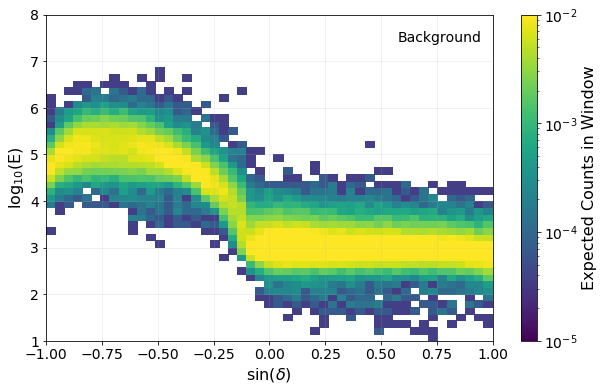

In [20]:
from matplotlib import colors

# Plot our signal and background energy distributions
bins = np.array([np.linspace(-1, 1, 50),
                 np.linspace(1, 8, 50)])
        
# background
fig, ax = plt.subplots(figsize=(10,6))
bg_w = np.ones(len(data), dtype=float) * time_window / grl['livetime'].sum()
bg_h, xedges, yedges, image = ax.hist2d(np.sin(data['dec']),
                                       data['logE'],
                                       bins=bins,
                                       weights = bg_w,
                                       norm = colors.LogNorm(),
                                       vmin = 1e-5,
                                       vmax = 1e-2)
cbar = plt.colorbar(image, ax=ax)

ax.text(0.95, 7.5, 
        "Background",
        horizontalalignment='right',
        verticalalignment='center',
        fontsize=14)

ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Expected Counts in Window", fontsize=16)
cbar.ax.tick_params(labelsize=14)

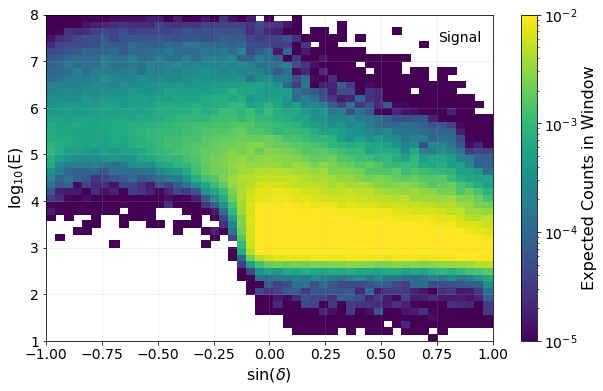

In [21]:
# Signal
fig, ax = plt.subplots(figsize=(10,6))
sig_w = sim['ow'] * 1e-15 * (sim['trueE']/100e3)**-2 * time_window * 24 * 3600
sig_h, xedges, yedges, image = ax.hist2d(np.sin(sim['dec']),
                                       sim['logE'],
                                       bins=bins,
                                       weights = sig_w,
                                       norm = colors.LogNorm(),
                                       vmin = 1e-5,
                                       vmax = 1e-2)
cbar = plt.colorbar(image, ax=ax)

ax.text(0.95, 7.5, 
        "Signal",
        horizontalalignment='right',
        verticalalignment='center',
        fontsize=14)

ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Expected Counts in Window", fontsize=16)
cbar.ax.tick_params(labelsize=14)


/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


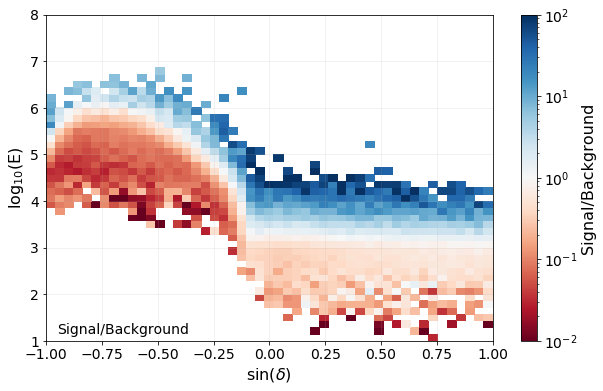

In [22]:
# Plot our signal and background ratio
fig, ax = plt.subplots(figsize=(10,6))

ratio = sig_h/bg_h

cmesh = ax.pcolormesh(xedges, yedges, ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)

ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)

ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)


In [23]:
# We want to spline this thing, but there are a
# lot of NaN values. We should be responsible and
# handle them properly. Let's do 1d splines
# for each dec first, then a final 2d interpolation
interpolated_ratio = np.copy(ratio)

for i in range(ratio.shape[0]):
    # Pick out the values we want to use.
    # We explicitly want to avoid NaNs and infinities
    values = ratio[i]
    good = np.isfinite(values) & (values>0)
    x, y = bins[1][:-1][good], values[good]
    
    # Do a linear interpolation across the energy range
    spline = scipy.interpolate.UnivariateSpline(x, y,
                                                k = 1,
                                                s = 0,
                                                ext = 3)
    
    # And store the interpolated values
    interpolated_ratio[i] = spline(bins[1,:-1])
    


/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [24]:
mask = (~np.isfinite(ratio)) | (ratio == 0)
idx = np.where(~mask,np.arange(mask.shape[1]),0)
np.maximum.accumulate(idx,axis=1, out=idx)
interpolated_ratio = ratio[np.arange(idx.shape[0])[:,None], idx][:,::-1]

mask = (~np.isfinite(interpolated_ratio)) | (ratio == 0)
idx = np.where(~mask,np.arange(mask.shape[1]),0)
np.maximum.accumulate(idx,axis=1, out=idx)
interpolated_ratio = interpolated_ratio[np.arange(idx.shape[0])[:,None], idx][:,::-1]


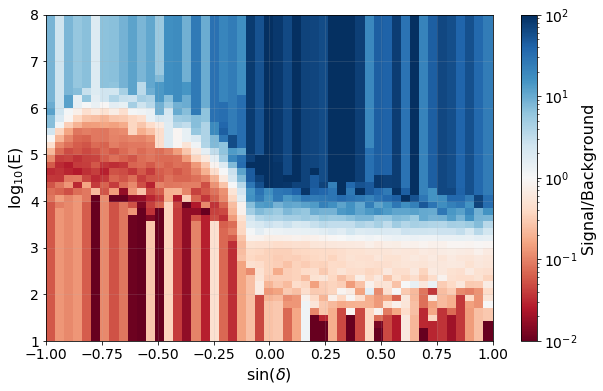

In [25]:
# Plot the interpolation
fig, ax = plt.subplots(figsize=(10,6))

cmesh = ax.pcolormesh(xedges, yedges, interpolated_ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)

ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [26]:
# Create a 2d spline. Since the values we're seeing 
# are anywhere from 1e-2 to 1e2, let's spline the log
# of the ratio instead.
from scipy.interpolate import RectBivariateSpline
sob_energy_spline = RectBivariateSpline(bins[0,:-1],
                                        bins[1,:-1],
                                        np.log(interpolated_ratio),
                                        kx=3, ky=1,
                                        s = 1e-10)

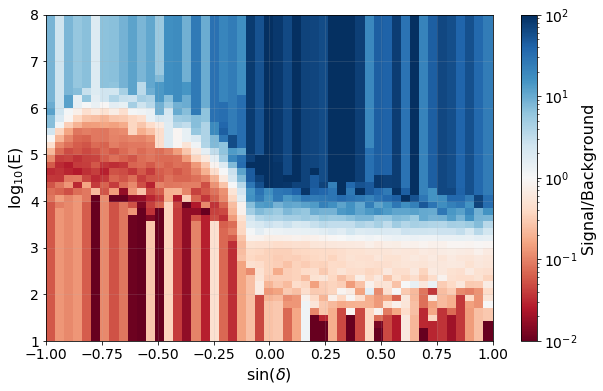

In [27]:
# Evaluate the spline at our bin points.
x, y = np.meshgrid(bins[0][:-1], bins[1][:-1])
x = x.flatten()
y = y.flatten()
splined_values = sob_energy_spline(bins[0][:-1], bins[1][:-1])

# We splined the log(ratio). Undo the log
splined_values = np.exp(splined_values)

# And plot the interpolation
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(xedges, yedges, splined_values.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)

ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [28]:
def create_interpolated_ratio(gamma,
                              data=data,
                              sim=sim,
                              bins = np.array([np.linspace(-1, 1, 50),
                                               np.linspace(1, 8, 50)])):
    
    # background
    bg_w = np.ones(len(data), dtype=float)
    bg_w /= np.sum(bg_w)
    bg_h, xedges, yedges  = np.histogram2d(np.sin(data['dec']),
                                           data['logE'],
                                           bins=bins,
                                           weights = bg_w)
    
    # signal
    sig_w = sim['ow'] * sim['trueE']**gamma
    sig_w /= np.sum(sig_w)
    sig_h, xedges, yedges = np.histogram2d(np.sin(sim['dec']),
                                           sim['logE'],
                                           bins=bins,
                                           weights = sig_w)
    
    ratio = sig_h / bg_h
    for i in range(ratio.shape[0]):
        # Pick out the values we want to use.
        # We explicitly want to avoid NaNs and infinities
        values = ratio[i]
        good = np.isfinite(values) & (values>0)
        x, y = bins[1][:-1][good], values[good]

        # Do a linear interpolation across the energy range
        spline = scipy.interpolate.UnivariateSpline(x, y,
                                                    k = 1,
                                                    s = 0,
                                                    ext = 3)

        # And store the interpolated values
        ratio[i] = spline(bins[1,:-1])
        
    return ratio, bins

In [29]:
def evaluate_interpolated_ratio(events,
                                bins = bins,
                                ratio = interpolated_ratio):
    # Get the bin that each event belongs to
    i = np.searchsorted(bins[0], np.sin(events['dec'])) - 1
    j = np.searchsorted(bins[1], events['logE']) - 1
    
    return ratio[i,j]

import time
start = time.time()
ratio, bins = create_interpolated_ratio(gamma=-2,)
mid = time.time()
print(evaluate_interpolated_ratio(sim[:10], bins=bins, ratio=ratio))
end = time.time()

print(mid-start)
print(end-mid)

[ 2.06796428 11.36642491  0.85105034  0.5716084   0.57062797  0.57182732
 18.65583476  0.57062797 25.77849147  0.63510825]
0.24051809310913086
0.0008120536804199219


/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


In [30]:
# Our events will consist of some unknown combination
# of signal events (described by the PDF "signal_pdf", S)
# and background events (described by "background_pdf", B).
# We'll call the number of signal events ns.
# Then the total likelihood will therefore be 
#
# L_i = (ns/N)*S + (nb/N)*B
#     = (ns/N)*S + ((N-ns)/N)*B
#
# which we will sum over all events i in our trial.
# We'll evaluate these at a "test point" in RA, dec.
def evaluate_ts(event,
                test_ra,
                test_dec,
                ns = 0,
                bins = bins,
                ratio = ratio,
                minimize = True):
    N = len(event)
    if N==0: 
        return 0, [-1,]
    
    # Check: ns cannot be larger than N.
    if ns > N: 
        ns = N - 0.0001

    S = signal_pdf(event, test_ra, test_dec)
    B = background_pdf(event, test_ra, test_dec)
    
    SoB = 1.0
    SoB *= evaluate_interpolated_ratio(event, 
                                     bins=bins, 
                                    ratio=ratio)
    SoB *= S/B

    def get_ts(ns):
        ts = (ns/N*(SoB-1))+1
        return -2*np.sum(np.log(ts))
    
    if minimize:
        result = scipy.optimize.minimize(get_ts,
                                         x0 = [ns,],
                                         bounds = [[0, N],],
                                         method = 'SLSQP',
                                         tol = 1e-5,)
        return -1*result.fun, result.x
    
    else:
        return -1*get_ts(ns), [ns,]

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


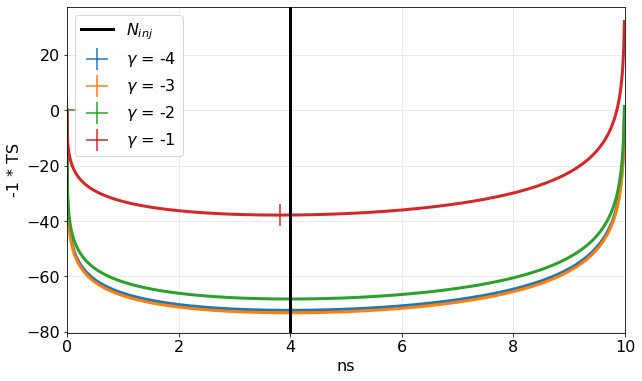

In [31]:
# Plot -1*LLH vs ns for this trial
# Note that we're going to plot -1*LLH here.
fig, ax = plt.subplots(figsize=(10,6))

for gamma in np.arange(-4, 0, 1):
    ratio, bins = create_interpolated_ratio(gamma=gamma,)

    # Produce a single trial that we can use to answer the
    # question "What does the TS look like as a function of ns?"
    trial = produce_trial(N=1e-15, gamma=-2, random_seed=0)

    ns_values = np.linspace(0, 10, 1000)
    ts_values = []
    for ns in ns_values:
        # Calculate the spatial LLH for this ns and trial
        # How do we call the spatial likelihood for this
        # trial and ns with a source at RA=pi/2, dec=pi/6?
        llh, _ = evaluate_ts(trial,
                              np.pi/2,
                              np.pi/6,
                              ns = ns,
                            bins = bins,
                            ratio = ratio,
                             minimize = False,)
        ts_values.append(llh)

    # numpy arrays are easier to do calculations with than lists
    ts_values = np.array(ts_values)

    # Add your plotting line here
    ax.plot(ns_values, 
            -1*ts_values,
            linewidth=3,)

    llh, [ns,] = evaluate_ts(trial,
                              np.pi/2,
                              np.pi/6,
                              ns = 0,
                            bins = bins,
                            ratio = ratio,
                             minimize = True,
                            )
    ax.scatter(ns, -1*llh,
               s = 512,
               marker = '+',
              label = r'$\gamma$ = '+str(gamma))
    
ns_true = (trial['run']>200000).sum()
ax.axvline(ns_true,
            color='k',
           linewidth=3,
            label = r'$N_{inj}$')

ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(ns_values.min(), ns_values.max())
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("-1 * TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [32]:
# Plot -1*LLH vs ns for this trial
# Note that we're going to plot -1*LLH here.
trial = produce_trial(N=1e-15, gamma=-2, random_seed=3)

gammas = np.linspace(-4, -1, 26)
ns_values = np.linspace(0, 10, 26)[1:]

x, y, z = [], [], []
for gamma in gammas[:-1]:
    ratio, bins = create_interpolated_ratio(gamma=gamma,)

    ts_values = []
    for ns in ns_values[:-1]:
        # Calculate the spatial LLH for this ns and trial
        # How do we call the spatial likelihood for this
        # trial and ns with a source at RA=pi/2, dec=pi/6?
        llh, _ = evaluate_ts(trial,
                              np.pi/2,
                              np.pi/6,
                              ns = ns,
                            bins = bins,
                            ratio = ratio,
                             minimize = False,)
        x.append(gamma)
        y.append(ns)
        z.append(llh)
        
x = np.array(x)
y = np.array(y)
z = np.array(z)

z[~np.isfinite(z)] = np.nan

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


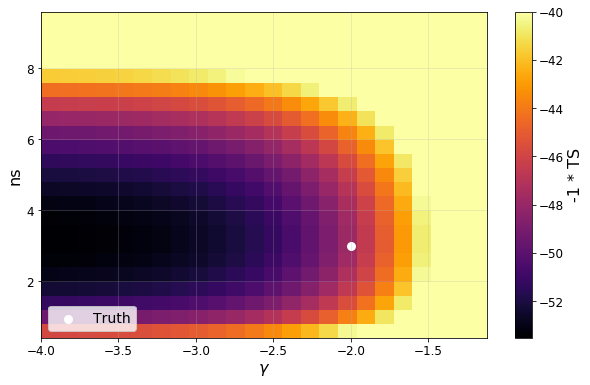

In [33]:
# Make it into a 2d histogram
fig, ax = plt.subplots(figsize=(10,6))
h, xedges, yedges, image = ax.hist2d(x, y,
                                      bins = (gammas, ns_values),
                                      weights = -1*z,
                                     vmax = -40,
                                      cmap = 'inferno',
                                    )

cbar = plt.colorbar(image, ax=ax)

ns_true = (trial['run']>200000).sum()
ax.scatter(-2, 
           ns_true,
            color='w',
           linewidth=3,
            label = r'Truth')

ax.legend(loc='lower left', fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel(r"$\gamma$", fontsize=16)
ax.set_ylabel("ns", fontsize=16)
cbar.ax.set_ylabel("-1 * TS", fontsize=16)
cbar.ax.tick_params(which='both', labelsize=12)
ax.tick_params(which='both', labelsize=12)